## Overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the delft3dfmpy python package.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook is part of D-Hydamo in delft3dfmpy version 1.0.0. It, however, also works with subsequent versions. Version 1.0.0 is 'frozen' and regarded as a functional and stable version. Further developments are implemented in newer versions. To choose which version to install, install the package using pip as:

For version 1.0.0:
```
pip install delft3dfmpy=1.0.0
```
Or a newer version:
```
pip install delft3dfmpy=1.1.3
```
In this way, the most recent version is installed:
```
pip install delft3dfmpy
```
This notebook is similar to the '_coupled_RRFM' variant, albeit that there is no RR component and all laterals are filled with time series.

## Release notes

In [1]:
# Basis
import os
import sys
import shutil
import numpy as np
sys.path.append(r'D:\Users\horn\Documents\D-Hydamo_cursus\delft3dfmpy-DSD_workshop_060721')      
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

### Read HYDAMO

Note: the data are also added in zipped format, to be unzipped in case of errors with the downloaded gml-files.

In the code section below the different parts or the HyDAMO gml are added. For more info on how to import the different elements from the HyDAMO gml, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing the HyDAMO files are:
- Read the objects from the GML file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number of features with a specfic name. If the name in the gml does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length o f10 characters, so probably a lot of column_mapping is necessary.

Change this path to access the data!

In [2]:
# path to the package containing the dummy-data
data_path = os.path.abspath(r'D:\Users\horn\Documents\D-Hydamo_cursus\delft3dfmpy-DSD_workshop_060721\data')
print(data_path)

# path to dflowfm for refining the mesh 
dflowfm_path = r'D:\dflow\dflowfm-x64-1.2.105.67228M'

# path to write the models
output_path = r'D:\Users\horn\Documents\D-Hydamo_cursus'

# path to DIMR for a correct run.bat file
dimr_path = r'D:\3640.20\software\x64\dimr\scripts\run_dimr.bat'

D:\Users\horn\Documents\D-Hydamo_cursus\delft3dfmpy-DSD_workshop_060721\data


In [3]:
# define all files needed below
fn_pilot_area = os.path.join(data_path, 'gis', 'selectie_pilot.shp')
fn_branches = os.path.join(data_path, 'gml', 'hydroobject.gml')
fn_crosssections = os.path.join(data_path, 'gml', 'dwarsprofiel.gml')
fn_profiles = os.path.join(data_path, 'gml', 'NormGeparametriseerdProfiel.gml')
fn_bridges = os.path.join(data_path, 'gml', 'brug.gml')
fn_culverts = os.path.join(data_path, 'gml', 'duikersifonhevel.gml')
fn_weirs = os.path.join(data_path, 'gml', 'stuw.gml')
fn_orifices = os.path.join(data_path, 'gml', 'onderspuier.gml')
fn_valves = os.path.join(data_path, 'gml', 'afsluitmiddel.gml')
fn_laterals = os.path.join(data_path, 'sobekdata', 'Sbk_S3BR_n.shp')
fn_pump1 = os.path.join(data_path, 'gml', 'gemaal.gml')
fn_pump2 = os.path.join(data_path, 'gml', 'pomp.gml')
fn_control = os.path.join(data_path, 'gml', 'sturing.gml')

# initialize the class
hydamo = HyDAMO(fn_pilot_area)

# Branches
hydamo.branches.read_gml(fn_branches, index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4

# read cross sections from GML
hydamo.crosssections.read_gml(fn_crosssections, 
                              column_mapping={'ruwheidswaardelaag':'ruwheidswaarde'} ,
                              index_col='profielcode' ,
                              groupby_column='profielcode' , 
                              order_column='codevolgnummer')

hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections.drop('code', axis=1, inplace=True)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)

hydamo.parametrised_profiles.read_gml(fn_profiles, column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'})
hydamo.parametrised_profiles.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.parametrised_profiles.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Bridges
hydamo.bridges.read_gml(fn_bridges)
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Culverts
hydamo.culverts.read_gml(
   fn_culverts,
   index_col='code',
   column_mapping={'vormkoker': 'vormcode'},
   clip=hydamo.clipgeo
)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
hydamo.culverts.drop(duikers_rekentijd, axis=0, inplace=True)
#Opdracht 1
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts.drop(duikers_gemalen, axis=0, inplace=True)
##Einde opdracht 1


# Weirs (including universal weirs)
hydamo.weirs.read_gml(fn_weirs)
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Orifices
hydamo.orifices.read_gml(fn_orifices)
hydamo.orifices.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.orifices.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Closing devices / terugslagkleppen e.d.
hydamo.afsluitmiddel.read_gml(fn_valves, index_col='code')

# Laterals (imported from shapefile)
hydamo.laterals.read_shp(fn_laterals,
                         column_mapping={'ID        ': 'code', 
                                         'NAME      ': 'name',
                                         'X         ':'X',
                                         'Y         ':'Y'})
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=  5)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Pumps
hydamo.gemalen.read_gml(fn_pump1, index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml(fn_pump2, index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml(fn_control, index_col='code')


Plot the model with branches, cross sections and structures. Note that compound structures are not plotted here as they do not have a geometry on their own; they are composed from their sub-structures that do have a geometry and are plotted here.

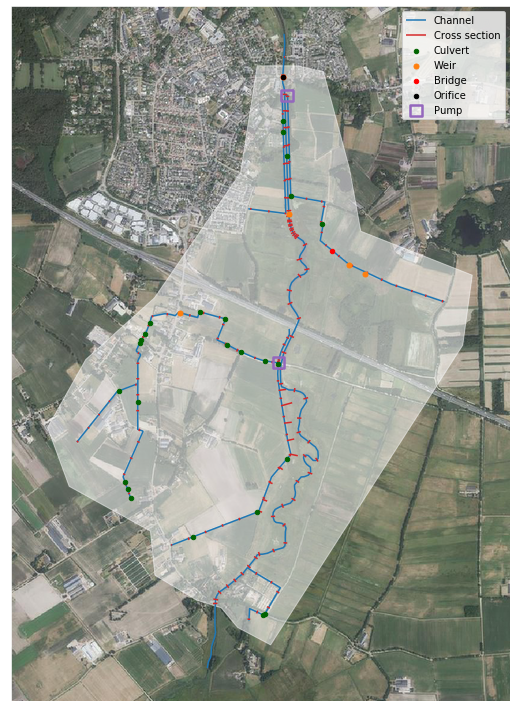

In [4]:
fn_background = os.path.join(data_path, 'gis', 'achtergrond.png')
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread(fn_background)
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel')
hydamo.crosssections.plot(ax=ax, color='C3', label='Cross section')
hydamo.culverts.centroid.plot(ax=ax, color='darkgreen', label='Culvert', markersize=20, zorder=10)
hydamo.weirs.centroid.plot(ax=ax, color='C1', label='Weir', markersize=25, zorder=10)
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10)
hydamo.orifices.plot(ax=ax,color='black',label='Orifice',markersize=20,zorder=10)
hydamo.pumps.plot(
    ax=ax, color='C4', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)

ax.legend()

fig.tight_layout()

### Generate the D-HYDRO FM schematisation

#### Create the 1D network

Convert the geometries to D-HYDRO schematisation:

Start with importing the structures (from HyDAMO in this case), since the position of the structure can be used in defining the position of the 1d nodes. 

Structures can also be added without the HyDAMO imports. One weir is added manually, but this can be done for all implemented structures.

Note that for importing most structures multiple gml-files are needed. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found (either a YZ or a parametrised profile) the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section should contain a 'codegeralateerdobject' containing the ID of the universal weir.
 - culverts can also use an 'afsluitmiddel'; if one is coupled for a specific culvert and its type is 5 (terugslagklep) the flow direction is set 'positive' instead of 'both'. If the type is 4 (schuif), a valve will be implemented.
 - bridges need an associated crosssection (through the field 'codegerelateerdobject' in the cross-section); this can be either 'YZ' or 'parametrised'. The profiles are then processed so a suitable cross-section for a bridge is created;
 - pumps are composed from 'gemalen', 'pompen' and 'sturing'.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects (gemalen, pompen en sturing);
- bridges really need a profile (either 'crosssections' or 'parametrised_profiles' needs to contain a field 'codegerelateerdobject' that points to each bridge).

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

Note that orifices do not yet have an appropriate/definitive definition in HYDAMO. To be able to use it, we now use a separate GML-definition ('onderspuier") but possibly this will be integrated in the definition for weirs. To be continued.


In [122]:
dfmmodel = DFlowFMModel()

# Collect structures
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, hydamo.afsluitmiddel)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.orifices_from_hydamo(hydamo.orifices)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)

#Opdracht 2: Add a weir manually (equivalent functions exist for all structures):
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='riv_RS1_1810',
    chainage=950.0,
    crestlevel=8.00,
    crestwidth=7.5,
    corrcoeff=1.0    
)
#Einde Opdracht 2

2021-07-07 12:11:43,261 - delft3dfmpy.converters.hydamo_to_dflowfm - hydamo_to_dflowfm - INFO - Currently only simple weirs can be applied. From Hydamo the attributes 'laagstedoorstroomhoogte' and 'kruinbreedte' are used to define the weir dimensions.


INFO:delft3dfmpy.converters.hydamo_to_dflowfm:Currently only simple weirs can be applied. From Hydamo the attributes 'laagstedoorstroomhoogte' and 'kruinbreedte' are used to define the weir dimensions.


For some structures it is possible to set a time series on their controls. Currently these are:
- for weirs, the crestlevel
- for orifices, the lower edge level of the gate
- for culverts, the valve opening height.

IN D-HYDRO, the associated parameter names are, respectively, 'weir_crestLevel', 'orifice_gateLowerEdgeLevel' and 'culvert_valveOpeningHeight', but for the converter it is sufficient to use only part of these names, for example 'crest' (or crestlevel), 'gate' , or 'valve'. It is case insensitive and the full names is then implemented in D-HYDRO input.

The time series should be provided as a pandas series, with timesteps as indices.

Structure types should be 'weir', 'orifice' or 'culvert'; other structures are not supported yet.

In [123]:
#  test crestLevel time series for weir Weir_RS373-st1
cl = pd.read_csv(data_path+'/sobekdata/crestlevel_weir_RS373-st1.csv', sep=';', index_col=0)
cl.index = pd.to_datetime(cl.index)
dfmmodel.external_forcings.set_structure_series('Weir_RS373-st1', 'weir','crest',cl)

D:\Users\horn\Documents\D-Hydamo_cursus\delft3dfmpy-DSD_workshop_060721\delft3dfmpy\core\dfm.py:320: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  startdate = pd.datetime.strftime(series.index[0],'%Y%m%d%H')


Text(0.5, 0, 'Time [minutes since start]')

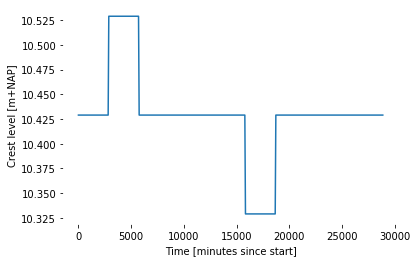

In [124]:
fig, ax = plt.subplots()
ax.plot(
    dfmmodel.external_forcings.structures.loc['Weir_RS373-st1']['time'],
    dfmmodel.external_forcings.structures.loc['Weir_RS373-st1']['value'],
    label='Crest level [m+NAP]'
)
ax.set_ylabel('Crest level [m+NAP]')
ax.set_xlabel('Time [minutes since start]')

Compound structures are composed of other structures and will not be implemented as such in HyDAMO. D-Flow FM simply needs an ID for every compound structure and a list of structures it should be composed of. They should be snapped to the same branch but not necessarily to the exact same location.

To use, provide a list of ID's of compound structures, and along with, for every compound structure, a nested list of sub-structures. If there are many, these can be read from files (for example).

In [125]:
cmpnd_ids  = ['cmpnd_1']
cmpnd_list = [['Orifice_Test1','UWeir_Test2']]
dfmmodel.structures.io.compound_structures(cmpnd_ids, cmpnd_list)

After this add the branches and generate a grid.

In [126]:
# Create a 1D schematisation
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=10.0, seperate_structures=True)

#Oefening 3: Antwoord (vergroten rekenpuntafstand naar 20m)
#dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=20.0, seperate_structures=True)
#Einde oefening 3

2021-07-07 12:11:44,396 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.


2021-07-07 12:11:44,402 - delft3dfmpy.core.dfm - dfm - WARNING - Structures UWeir_Test2, Orifice_Test1 have the same location.


2021-07-07 12:11:44,404 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch riv_RS1_264 at: [0.0, 104.16550000000001, 348.33320917846794], due to the structures at [-0.001, 104.147, 104.184, 348.3342091784679].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch riv_RS1_264 at: [0.0, 104.16550000000001, 348.33320917846794], due to the structures at [-0.001, 104.147, 104.184, 348.3342091784679].


Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

In [127]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    dwarsprofielen=hydamo.crosssections,
    parametrised=hydamo.parametrised_profiles,
    branches=hydamo.branches
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

2021-07-07 12:11:44,718 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of branches without cross section is: 16.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of branches without cross section is: 16.


2021-07-07 12:11:44,924 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 2.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 2.


2021-07-07 12:11:44,949 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of branches without cross section is: 1.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of branches without cross section is: 1.


2021-07-07 12:11:44,951 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of structures without cross section is: 2.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of structures without cross section is: 2.


2021-07-07 12:11:44,977 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 1.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 1.


2021-07-07 12:11:44,991 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of structures without cross section is: 0.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of structures without cross section is: 0.


1 branches are still missing a cross section.
0 structures are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

In [128]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30)
dfmmodel.crosssections.set_default_definition(definition=default, shift=5.0)

#Oefening 4 verander de standaardprofielbreedte en ruwheid naar 6m en 26
#default = dfmmodel.crosssections.add_rectangle_definition(
#    height=5.0, width=6.0, closed=False, roughnesstype='Strickler', roughnessvalue=26)
#dfmmodel.crosssections.set_default_definition(definition=default, shift=5.0)
#einde oefening 4


#### Add a 2D mesh

To add a mesh, currently 2 options exist:

1) the converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

The 'refine'-method requires the dflowfm.exe executable. If this is not added to the system path, it can be provided in an optional argument to refine (dflowfm_path).

In [129]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

#Oefening 1 2D:
#cellsize = 25
#Einde oefening 1 2D

# Generate mesh within model bounds
mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(25)
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=dflowfm_path)

#####Oefening lateraal koppelen
#buffered_branch = hydamo.branches.loc[['riv_RS373_2442'], 'geometry'].unary_union.buffer(25)
#mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=dflowfm_path)
#buffered_branch = hydamo.branches.loc[['riv_RS373_2442'], 'geometry'].unary_union.buffer(5)
#mesh.clip_mesh_by_polygon([buffered_branch])
#####Einde oefening lateraal koppelen

# Determine the altitude from a digital elevation model
#rasterpath = '../gis/AHNdommel_clipped.tif'
#mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
mesh.altitude_constant(15.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

2021-07-07 12:11:46,216 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Generating grid with cellsize 25 m and rotation 0 degrees.


INFO:delft3dfmpy.core.mesh2d:Generating grid with cellsize 25 m and rotation 0 degrees.


2021-07-07 12:11:46,262 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Selecting nodes within polygon.


INFO:delft3dfmpy.core.mesh2d:Selecting nodes within polygon.


2021-07-07 12:11:46,269 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Creating LineString for each edge.


INFO:delft3dfmpy.core.mesh2d:Creating LineString for each edge.


2021-07-07 12:11:46,408 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Checking for intersections.


INFO:delft3dfmpy.core.mesh2d:Checking for intersections.


2021-07-07 12:11:46,479 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Remove edges with only a single node within the clip area.


INFO:delft3dfmpy.core.mesh2d:Remove edges with only a single node within the clip area.


Before find_cells (numnodes):  6264
Before find_cells (numedge):  12304
Error message 1:
0
Error message 2:
0
meshname       : <ctypes.LP_c_char object at 0x000001B65FF8F2C8>
dim            : 0
numnode        : 0
numedge        : 0
numface        : 6041
maxnumfacenodes: 4
numlayer       : 0
layertype      : 0
nnodes         : 0
nbranches      : 0
ngeometry      : 0
epgs           : 0


2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to activate)

In [130]:
#from dhydamo.core.mesh2d import Mesh2D
#mesh = Mesh2D()
# import the geometry
# mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
#mesh.altitude_from_raster(rasterpath)
# and add to the model
#dfmmodel.network.add_mesh2d(mesh)

#### Save a mesh

Een mesh kan opgeslagen worden en later weer opnieuw ingeladen

In [131]:
#from delft3dfmpy.io import gridio
#gridio.to_netcdf_old(dfmmodel.network.mesh2d, r'D:\Users\horn\Documents\D-Hydamo_cursus\test.nc' )

#### Add the 1D-2D links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==True).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [132]:
del dfmmodel.network.links1d2d.faces2d[:]
del dfmmodel.network.links1d2d.nodes1d[:]
dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

#####Oefening lateraal koppelen
#dfmmodel.network.links1d2d.generate_2d_to_1d(max_distance=200,intersecting=False)
#####Einde oefening lateraal koppelen

2021-07-07 12:11:49,353 - delft3dfmpy.core.dfm - dfm - INFO - Generating links from 2d to 1d based on distance.


INFO:delft3dfmpy.core.dfm:Generating links from 2d to 1d based on distance.


2021-07-07 12:11:50,588 - delft3dfmpy.core.dfm - dfm - INFO - Creating GeoDataFrame of (4606) 2D cells.


INFO:delft3dfmpy.core.dfm:Creating GeoDataFrame of (4606) 2D cells.


2021-07-07 12:11:50,735 - delft3dfmpy.core.dfm - dfm - INFO - Determine intersecting or nearest branches.


INFO:delft3dfmpy.core.dfm:Determine intersecting or nearest branches.


2021-07-07 12:11:56,889 - delft3dfmpy.core.dfm - dfm - INFO - Remove links that cross another 2D cell.


INFO:delft3dfmpy.core.dfm:Remove links that cross another 2D cell.


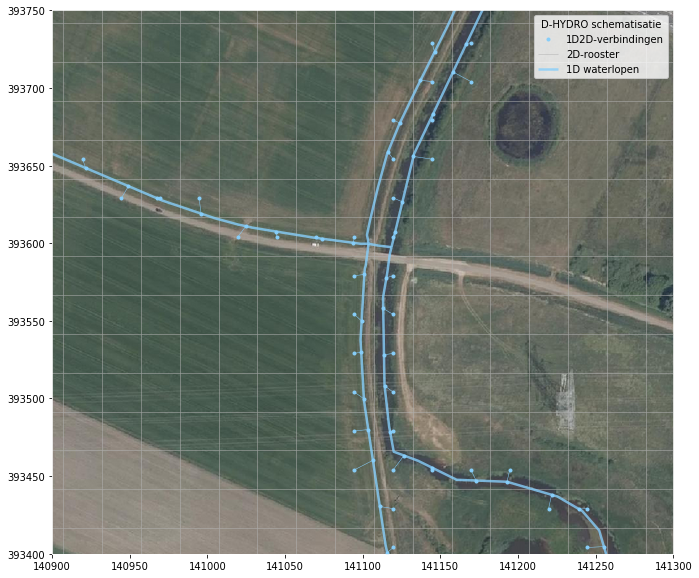

In [133]:
#fn_background_2 = os.path.join(data_path, 'gis', 'achtergrond_v2.png')

fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)
#achtergrond = plt.imread(fn_background_2)
#ax.imshow(achtergrond, extent=(140772.14200658097979613,141460.1,393352.2,393823.05226060951827094), interpolation='lanczos')

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-rooster'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='lightskyblue', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='lightskyblue', marker='.', ls='', label='1D2D-verbindingen')

#for i, p in enumerate([buffered_branch]):
#    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='lightskyblue', lw=2.5, alpha=0.8, label='1D waterlopen')

ax.legend(title='D-HYDRO schematisatie')

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

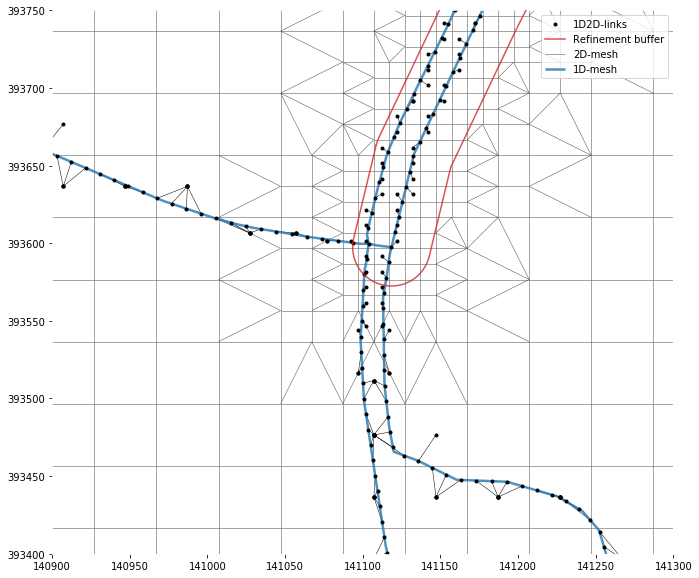

In [145]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

### Boundary conditions for FM

Add boundary conditions to external forcings from a SOBEK time series.

In [124]:
fn_bcs = os.path.join(data_path, 'sobekdata', 'boundaryconditions.csv')
bcs = pd.read_csv(fn_bcs, sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)

In [125]:
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_flow_in',
    pt=(140712.056047, 391893.277878),
    bctype='discharge',
    series=bcs['Discharge']
)

#Oefening 5
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_wlev_down',
    pt=(141133.788766, 395441.748424),
    bctype='waterlevel',
    series=bcs['Waterlevel']
)
#Einde oefening 5

D:\Users\horn\Documents\D-Hydamo_cursus\delft3dfmpy-DSD_workshop_060721\delft3dfmpy\core\dfm.py:236: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  startdate = pd.datetime.strftime(series.index[0],'%Y-%m-%d %H:%M:%S')


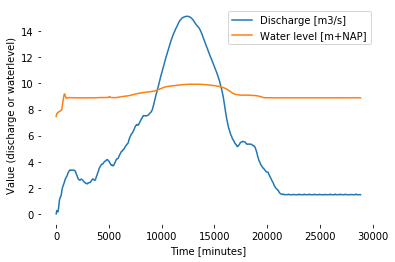

In [126]:
fig, ax = plt.subplots()

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_flow_in']['time'],
    dfmmodel.external_forcings.boundaries['BC_flow_in']['value'],
    label='Discharge [m3/s]'
)

#Oefening 5
ax.plot(
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['time'],
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['value'],
    label='Water level [m+NAP]'
)
#Einde oefening 5

ax.set_ylabel('Value (discharge or waterlevel)')
ax.set_xlabel('Time [minutes]')

ax.legend();

### Initial conditions

There are four ways to set the initial conditions. First, global water level or depth can be set. In the example, we use a global water depth of 0.5 m, but we could also use the equivalent function "set_initial_waterlevel".

In [127]:
# Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

It is also possible to define a certain area, using a polygon, with alternative initial conditions (level or depth).

In [128]:
init_special = gpd.read_file(data_path+'/GIS/init_waterlevel_special.shp')
dfmmodel.external_forcings.set_initial_waterlevel(10.0, polygon=init_special.geometry[0], name='test_polygon')

### Lateral flow

Lateral flow can be obtained from the coupling with the RR-model, or by providing time series. Here, these are read from a Sobek model. In the coupling below, nodes that are not linked to a RR-boundary node are assumed to have a prescribed time series.

If a DFM-model is run offline, timeseries should be provided for all laterals.

In [129]:
###For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy
# # Add the lateral inflows also from the SOBEK results. Naote that the column names in the his-file need to match
# # the id's of the imported lateral locations at the top of this notebook.
rehis = hkvsobekpy.read_his.ReadMetadata(data_path+'/sobekdata/QLAT.HIS', hia_file='auto')
param = [p for p in rehis.GetParameters() if 'disch' in p][0]
lateral_discharge = rehis.DataFrame().loc[:, param]
lateral_discharge.drop('lat_986', inplace=True, axis=1)

In [130]:
dfmmodel.external_forcings.io.read_laterals(hydamo.laterals, lateral_discharges=lateral_discharge)

2021-07-06 10:47:36,277 - delft3dfmpy.io.dfmreader - dfmreader - WARNING - No data found for lat_986. Skipping.


### Observation points

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates.

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore. Observation point coordinates can be definied eiher as an (x,y)-tuple or as a shapely Point-object.

In [131]:
from shapely.geometry import Point
dfmmodel.observation_points.add_points([Point((141150, 393700)),(141155, 393705),Point((145155, 394705)),(145150, 394700)],['ObsPt1','ObsPt2','ObsPt2D1','ObsPt2D2'], locationTypes=['1d','1d','2d','2d'])

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. Note that both the GUI and Interaktor do not (yet) support RR, so the only way to carry out a coupled simulation is using DIMR.


In [132]:
# Runtime and output settings
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] = 24.0 * 1 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# Create writer
dfmmodel.dimr_path = dimr_path
fm_writer = DFlowFMWriter(dfmmodel, output_dir=output_path, name='moergestels_broek')

# Write as model
fm_writer.objects_to_ldb()
fm_writer.write_all()

C:\Users\horn\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Finished!